In [61]:

from pyPPG import PPG, Fiducials
from pyPPG.datahandling import load_data
import pyPPG.fiducials as FP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, tf2zpk, freqz, cheby2, firwin


def plot_pole_zero(b, a, title: str = 'Pole-Zero Plot') -> None:
    z, p, k = tf2zpk(b, a)

    plt.figure(figsize=(8, 8))
    plt.scatter(np.real(z), np.imag(z), marker='o', color='blue', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='red', label='Poles')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    plt.title(title)
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.grid()
    plt.legend()
    plt.show()


def plot_bode(b, a, fs, title: str = 'Bode Plot') -> None:
    nyq_rate = fs/2
    w, h = freqz(b, a, worN=8000)
    #plt.plot((w/np.pi)*nyq_rate, np.log10(abs(h)), linewidth=2)

    # Magnitude plot
    plt.subplot(2, 1, 1)
    f = (w/np.pi)*nyq_rate
    plt.semilogx(f, np.log10(abs(h)), color='blue')
    plt.title(f'{title} - Magnitude Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Phase plot
    plt.subplot(2, 1, 2)
    plt.semilogx(f, np.angle(h, deg=True), color='red')
    plt.title('Phase Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [degrees]')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

def detect_and_plot_peaks(signal, title='PPG Peaks'):
    signal.vpg = np.gradient(signal.ppg)
    signal.apg = np.gradient(signal.vpg)
    signal.jpg = np.gradient(signal.apg)
    s = PPG(s=signal, check_ppg_len=check_ppg_len)

    fpex = FP.FpCollection(s=s)

    corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
    correction.loc[0, corr_on] = True
    signal.correction=correction

    # Extract fiducial points
    fiducials = fpex.get_fiducials(s=s)
    fp = Fiducials(fp=fiducials)
    #print(fiducials)
    #plot_fiducials(s=s, fp=fp, savefig=savefig, show_fig=show_fig, print_flag=print_flag, use_tk=use_tk)
    # copied from https://github.com/godamartonaron/GODA_pyPPG/blob/main/pyPPG/datahandling.py#

    marker=[]
    marker_size=60
    marker = ['o', 's', 's','o', 'o', 's', 'o', 'o', 's', 'o', 's', 'o', 's', 'o', 's']
    color = ['r', 'b', 'g','m', 'r', 'b', 'g', 'r', 'b', 'g', 'm', 'c', 'k', 'r', 'b']
    fid_names = ('sp', 'on', 'dn','dp')
    str_sig = 0
    end_sig = len(s.ppg)
    len_sig=end_sig-str_sig
    step_small = 1
    if len_sig/s.fs<10:
        step_big = step_small * 1
    else:
        step_big = step_small * 5
    len_sig_sec=int(len_sig / s.fs)
    if len_sig_sec<1:
        len_sig_sec=1

    major_ticks_names = range(0,len_sig_sec,step_big)
    len_ticks_names=len(major_ticks_names)
    major_diff=len_sig/len_ticks_names
    major_ticks = np.arange(str_sig, end_sig, major_diff)
    major_ticks = major_ticks[0:len_ticks_names]
    plt.plot(s.ppg, 'k', label=None)
    for n in fid_names:
        ind = fid_names.index(n)
        plt_num = 1
        plt.subplot(111)
        plt.title(title, fontsize=20)
        ax = plt.subplot(1, 1, plt_num)
        tmp_pnt=eval("fp." + n + ".values")
        tmp_pnt=tmp_pnt[~np.isnan(tmp_pnt)].astype(int)
        tmp_sig=eval("s.ppg")
        plt.scatter(tmp_pnt, tmp_sig[tmp_pnt], s=marker_size,linewidth=2, marker = marker[ind], facecolors='none', color=color[ind], label=n)
    plt.xlabel('Time [s]', fontsize=20)
    plt.xticks(major_ticks, major_ticks_names, fontsize=20)
    if show_fig:
        plt.show()



In [62]:
import tempfile
data_path=""
fs=0
start_sig=0
end_sig=-1
fiducials=pd.DataFrame()
process_type="both"
channel="Pleth"
filtering=True
fL=0.5000001
fH=12
order=4
sm_wins={'ppg':50,'vpg':10,'apg':10,'jpg':10}
correction=pd.DataFrame()
plotfig=True
savingfolder="temp_dir"
savefig=False
show_fig=True
savingformat="both"
print_flag=True
use_tk=False
check_ppg_len=True
saved_fiducials=""
savedata=True
points_to_plot = 2000



data = pd.read_csv("assets/data_predicted.csv", index_col='N')

# for...
#signal = pd.read_csv(f"assets/ecg_from_video/{row['Recording']}.csv")
wtf = pd.read_csv(f"assets/ecg_from_video/15:50:04.csv")
#signal.plot()



# Load into PyPPG
# TODO:
# Dear PyPPG maintainers: please document that `load_data` expects a mat file
# And that the mat file should contain a field `Data` with a 1d array, and a field `Fs` with the sampling rate.
with tempfile.NamedTemporaryFile(suffix='.mat') as temp:
    scipy.io.savemat(temp.name, {
        'Data': wtf['signal'].values,
        'Fs': wtf['time'].shape[0] / (wtf['time'].iloc[-1] - wtf['time'].iloc[0]),
    })
    signal = load_data(data_path=temp.name, fs=fs, start_sig=start_sig, end_sig=end_sig, channel=channel, use_tk=True, print_flag=print_flag)



a [ 1.         -1.46102034 -0.96498202  1.1530061   1.47965583 -0.70532813
 -0.82483191  0.12333209  0.20112389]
b [ 0.44830243 -0.18822325 -1.38828924  0.14372273  1.9690702   0.14372273
 -1.38828924 -0.18822325  0.44830243]


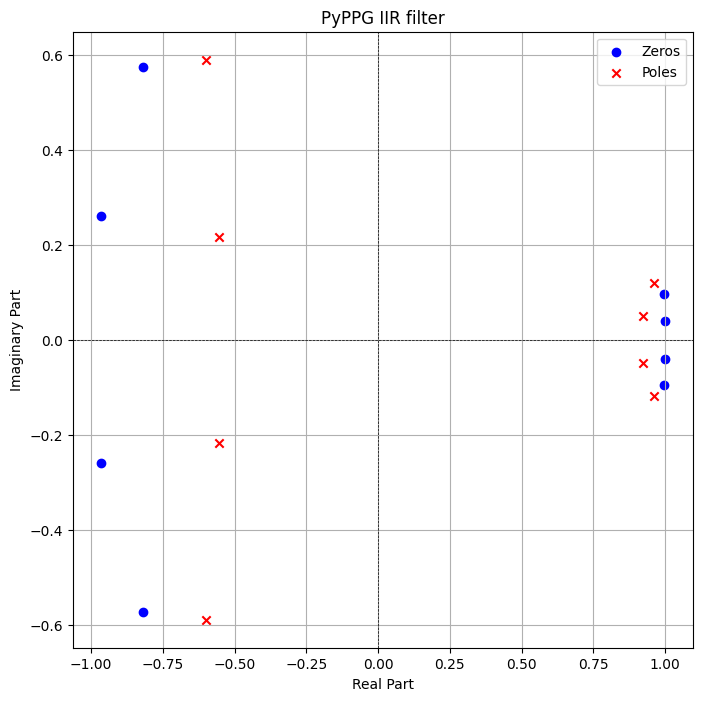

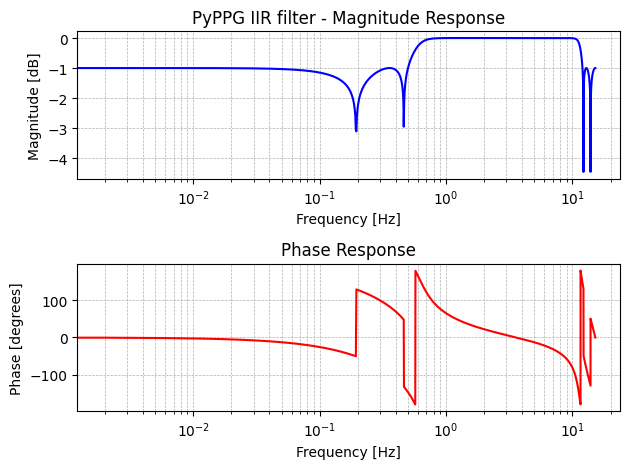

In [63]:
s=signal
b, a = cheby2(order, 20, [fL,fH], 'bandpass', fs=s.fs)
print('a', a)
print('b', b)
ppg_cb2 = filtfilt(b, a, s.v)
plot_pole_zero(b, a, title='PyPPG IIR filter')
plot_bode(b, a, s.fs, title='PyPPG IIR filter')

win = round(s.fs * sm_wins['ppg']/1000)
b = 1 / win * np.ones(win)
a = 1
ppg = filtfilt(b, a, ppg_cb2)
filtered_iir = ppg
filtered_iir = filtered_iir[:points_to_plot-740]

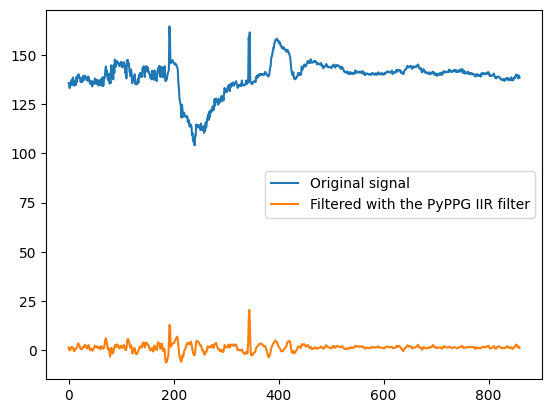

In [64]:
plt.plot(signal.v[:points_to_plot], label='Original signal')
plt.plot(filtered_iir[:points_to_plot], label='Filtered with the PyPPG')
plt.legend()
plt.show()

In [5]:
type(signal)

dotmap.DotMap

In [2]:
import pandas as pd

<AxesSubplot: >

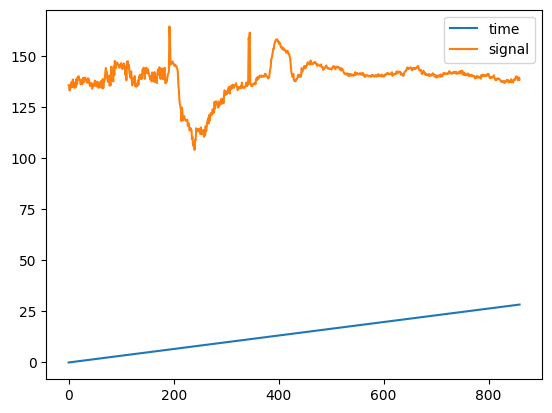

30.338660179781996

860

In [50]:
import scipy.io



In [22]:
data = scipy.io.loadmat('assets/PPG.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Nov 20 15:20:16 2023',
 '__version__': '1.0',
 '__globals__': [],
 'Data': array([[1.45845552],
        [1.45063539],
        [1.44672532],
        ...,
        [1.64711632],
        [1.59237537],
        [1.54252199]]),
 'Fs': array([[125]], dtype=uint8)}

In [24]:
data['Data'].shape

(15001, 1)

In [30]:
wtf = scipy.io.loadmat('assets/WTF.mat')
wtf

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Dec  4 17:15:36 2024',
 '__version__': '1.0',
 '__globals__': [],
 'Data': array([[135.65510033, 135.13421474, 133.13891802, 135.82593278,
         134.52676264, 137.0869856 , 137.09062542, 134.8824894 ,
         138.5371147 , 134.88065476, 135.48341385, 134.3920068 ,
         135.81576812, 137.32552146, 134.81833401, 138.87406763,
         136.34722959, 139.56254209, 139.4946736 , 140.14170692,
         138.41760684, 138.62830476, 137.79340584, 136.20491049,
         138.22170846, 137.57835602, 136.23162661, 139.20489233,
         138.53482609, 137.20992593, 139.36203846, 139.46637665,
         139.09663462, 138.62853925, 137.37126697, 137.38145485,
         136.8869858 , 139.12689738, 138.75824176, 138.03693122,
         136.0659621 , 135.3338538 , 136.1869625 , 136.85807008,
         135.36626005, 134.02159415, 136.47996633, 135.37160494,
         135.22446456, 136.47269426, 137.99715463, 135.69467787,
         13

In [32]:
wtf['Data'].shape

(1, 860)